In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
#from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, ParameterGrid
from time import time
import tensorflow as tf


# Crop yield dataset

In [2]:
df = pd.read_csv("crop_yield_dataset.csv")
df = df.set_index('Date')
df.drop("Crop_Type",axis=1,inplace=True)
wheat = df.iloc[::10].copy()
rice = df.iloc[2::10].copy()
tomato = df.iloc[7::10].copy()
potato = df.iloc[8::10].copy()

crop = rice

crop = crop[["Crop_Yield","Temperature","Humidity"]]

In [ ]:
best_mae = 1
best_params = None
for params in ParameterGrid(param_grid):
    print(f"Testing with parameters: {params}")
    mae = evaluate_model(params['layers'], params['units1'],params['units2'])
    print(f"MAE: {mae:.4f}")

    if mae < best_mae:
        best_mae = mae
        best_params = params

print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae:.4f}")

Testing with parameters: {'layers': 2, 'units1': 150, 'units2': 100}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


KeyboardInterrupt: 

In [29]:
def create_forecast(crop, cropname):
  crop = crop[["Crop_Yield","Temperature","Humidity"]]

  # univariate data splitting
  X = crop.drop("Crop_Yield",axis=1)
  y = crop["Crop_Yield"]
  test_split = round(len(crop)*0.8)
  train_set = crop[0:test_split]
  test_set = crop[test_split:]

  scaler = MinMaxScaler()
  train_set_sc = scaler.fit_transform(train_set)
  test_set_sc= scaler.transform(test_set)

  def createXY(dataset,time_step):
      dataX = []
      dataY = []
      for i in range(len(dataset)-time_step):
              dataX.append(dataset[i:i + time_step][:,0:2])
              dataY.append(dataset[i + time_step][0])
      return np.array(dataX),np.array(dataY)

  X_train, y_train=createXY(train_set_sc,10)
  X_test,y_test=createXY(test_set_sc,10)

  print("trainX Shape-- ",X_train.shape)
  print("trainY Shape-- ",y_train.shape)

  def evaluate_model(layers,units1,units2):
      model = Sequential()
      n_samples, n_timesteps, n_features = X_train.shape[0],X_train.shape[1],X_train.shape[2]
      for i in range(layers-1): #add one layer per number inputted
          model.add(GRU(units2,activation='relu',input_shape=(n_timesteps, n_features),return_sequences=True))
      model.add(GRU(units1,activation='relu',return_sequences=False))
      model.add(Dense(3)) #3 outputs
      model.compile(optimizer='adam',loss='mae')

      epochs = 50
      validation_split = 0.2
      batch_size = 64
      model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,validation_split=validation_split,verbose=1,shuffle=True)
      y_pred = model.predict(X_test, verbose=0)

      mae = np.sqrt(mean_absolute_error(y_test,y_pred))

      return mae

  best_mae = 0.3276
  best_params = {'layers': 2, 'units1': 150, 'units2': 50}
  print(f"Best Parameters: {best_params}")
  print(f"Best RMSE: {best_mae:.4f}")

  # train model with best params
  n_samples, n_timesteps, n_features = X_train.shape[0],X_train.shape[1],X_train.shape[2]
  model_GRU = Sequential()
  model_GRU.add(GRU(100, activation='relu', input_shape=(n_timesteps, n_features),return_sequences=True)) #return_sequences is necessary for stacked LSTM so that output includes timestamps (3D)
  model_GRU.add(GRU(50, activation='relu', return_sequences=True))
  model_GRU.add(GRU(50, activation='relu'))
  model_GRU.add(Dense(1)) #3 output variables (yield)
  model_GRU.compile(optimizer='adam', loss='mae')

  epochs = 100
  validation_split = 0.2
  batch_size = 64

  st = time()
  model_GRU_trained = model_GRU.fit(X_train,y_train,epochs=epochs,validation_split=validation_split,verbose=1,shuffle=True)
  et = time()
  train_t_LSTM = et-st

  plt.plot(model_GRU_trained.history['loss'])
  plt.plot(model_GRU_trained.history['val_loss'])
  plt.title(f'Model Loss: {cropname}')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  # Evaluate LSTM
  loss_gru = model_GRU.evaluate(X_test, y_test, verbose=0)
  y_pred_gru = model_GRU.predict(X_test, verbose=0)
  mae_gru = mean_absolute_error(y_test, y_pred_gru)
  rmse_gru = root_mean_squared_error(y_test,y_pred_gru)

  print(f"GRU Loss (MAE): {loss_gru}")
  print(f"GRU RMSE: {rmse_gru}")
  print(f"GRU Time: {train_t_LSTM}")

  plt.figure(figsize=(12,10))
  plt.plot(y_test,label="Actual")
  plt.plot(y_pred_gru,label="Predicted")
  plt.title(f'Crop Yield Prediction: {cropname}')
  plt.xlabel('Days')
  plt.ylabel('Crop Yield')
  plt.legend()

  last_input = X_test[-10:]  # Get the last input from the test set
  predictions = []

  for i in range(730):
      # Reshape last_input for prediction
      next_pred = model_GRU.predict(last_input,verbose=0)
      predictions.append(next_pred[0][0])

      # Prepare next input: append the new prediction and shift the window (if time series)
      # Adjust the last_input based on how your data is structured
      last_input = np.roll(last_input, -1)  # Shift left by 1
      last_input[-1] = next_pred  # Add new prediction at the end


  #Visualize the predicted temperatures for the next 10 days
  days = 365
  plt.figure(figsize=(10, 6))
  plt.plot(range(len(y_test[:50])),y_test[:50],label='real') # Changed range(365) to range(len(y_test[:50]))
  plt.plot(range(len(y_test[:50]),len(y_test[:50])+days),predictions[:days], label='Forecasted Crop Yield')  #Adjusted x-axis range for the prediction plot
  plt.xlabel('Day')
  plt.ylabel('Crop Yield')
  plt.title(f'Predicted Crop Yield for the Next 365 Days: {cropname}')
  plt.legend()
  plt.show()



# **WHEAT**

trainX Shape--  (2912, 10, 2)
trainY Shape--  (2912,)
Best Parameters: {'layers': 2, 'units1': 150, 'units2': 50}
Best RMSE: 0.3276
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 0.1987 - val_loss: 0.1476
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1503 - val_loss: 0.1430
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1511 - val_loss: 0.1396
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1494 - val_loss: 0.1424
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.1467 - val_loss: 0.1409
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1449 - val_loss: 0.1403
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1448 - val_loss: 0.1390
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1460 - val_loss: 0.1404
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.1510 - val_loss: 0.1379
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1465 - val_loss: 0.1383
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1470 - val_loss: 0.1383
Epoch 12/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.1

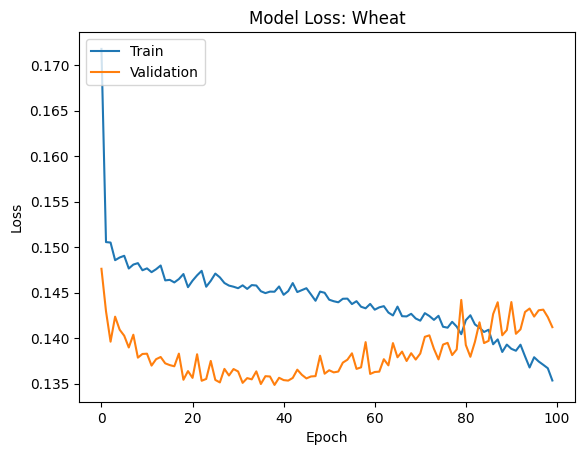

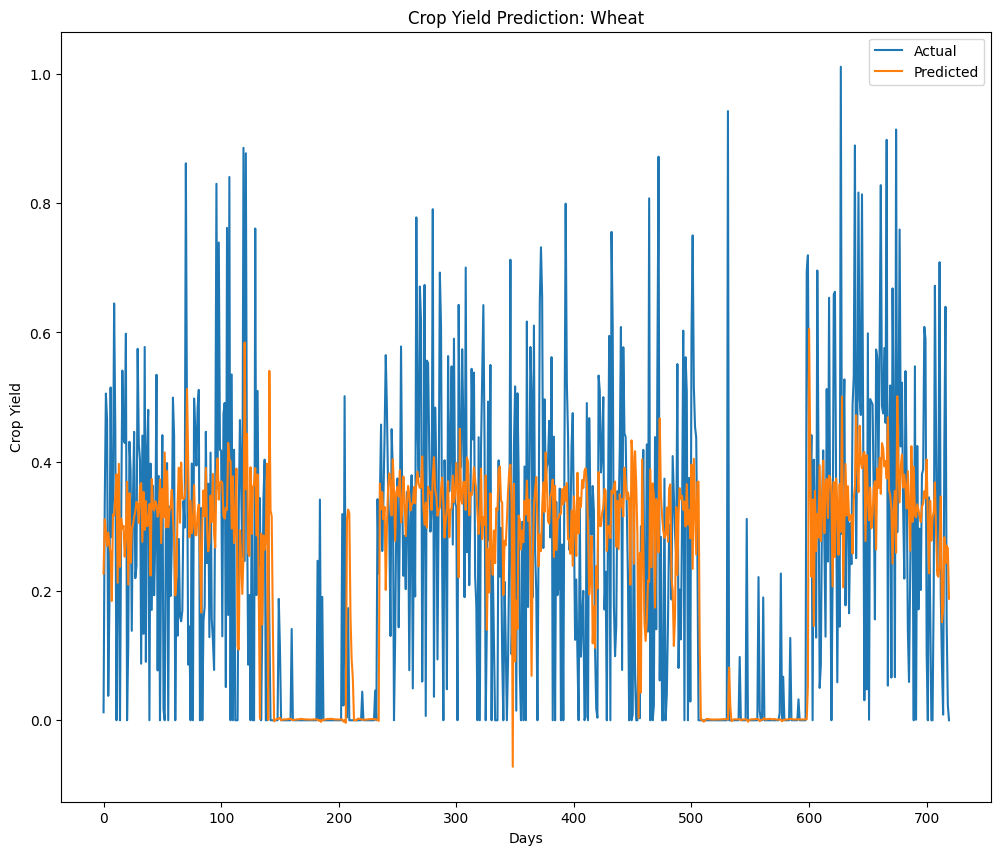

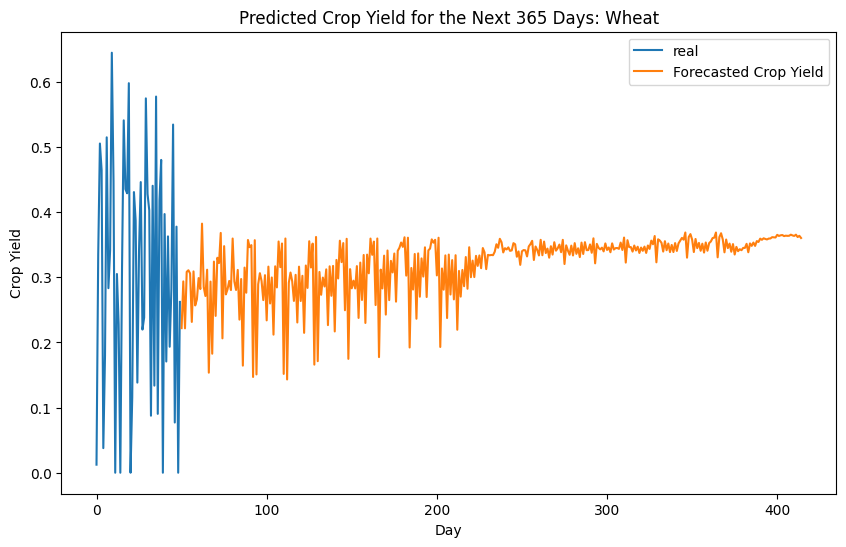

In [30]:
name = "Wheat"
create_forecast(wheat, name)

# **RICE**

trainX Shape--  (2912, 10, 2)
trainY Shape--  (2912,)
Best Parameters: {'layers': 2, 'units1': 150, 'units2': 50}
Best RMSE: 0.3276
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.2016 - val_loss: 0.1632
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1650 - val_loss: 0.1607
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1578 - val_loss: 0.1648
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.1599 - val_loss: 0.1606
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1621 - val_loss: 0.1624
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1590 - val_loss: 0.1679
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1620 - val_loss: 0.1648
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1626 - val_loss: 0.1599
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1637 - val_loss: 0.1600
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1611 - val_loss: 0.1593
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.1623 - val_loss: 0.1605
Epoch 12/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1

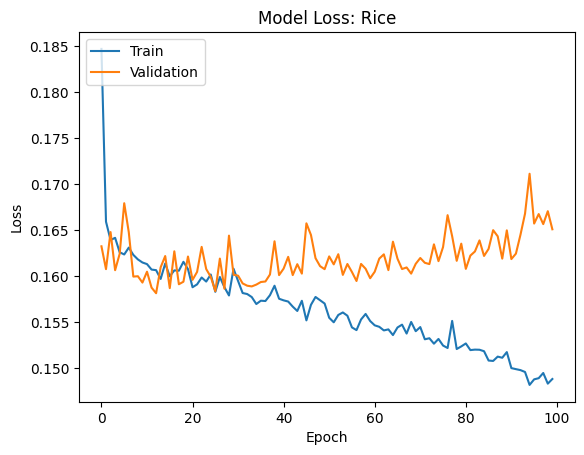

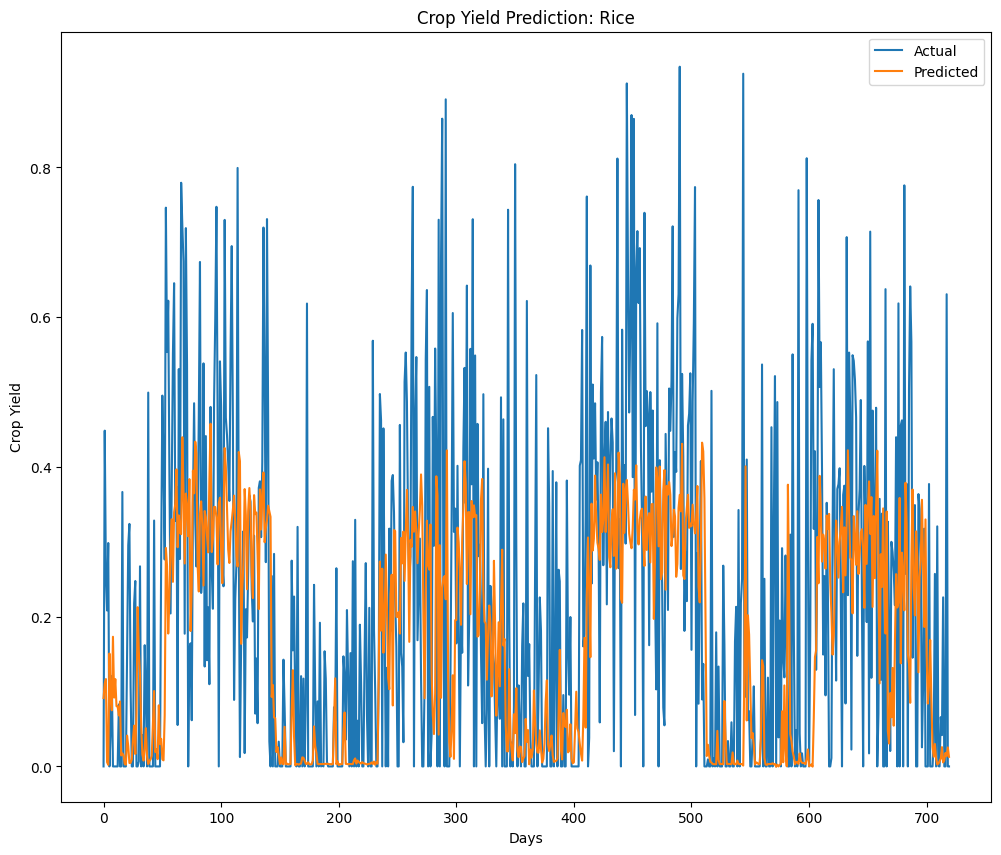

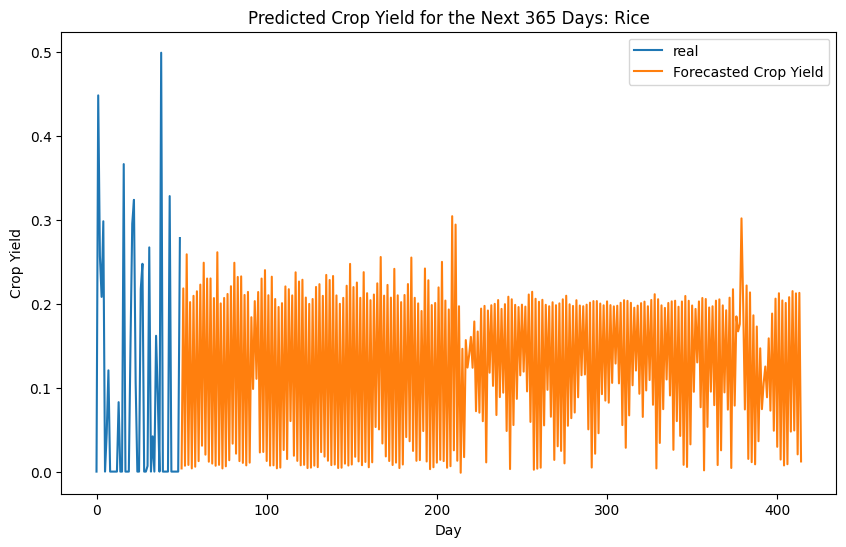

In [32]:
name2 = "Rice"
create_forecast(rice, "Rice")

# **TOMATO**

trainX Shape--  (2912, 10, 2)
trainY Shape--  (2912,)
Best Parameters: {'layers': 2, 'units1': 150, 'units2': 50}
Best RMSE: 0.3276


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 0.1944 - val_loss: 0.1625
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1680 - val_loss: 0.1642
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1640 - val_loss: 0.1638
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.1659 - val_loss: 0.1610
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.1702 - val_loss: 0.1697
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.1716 - val_loss: 0.1603
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1669 - val_loss: 0.1621
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1626 - val_loss: 0.1623
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.1662 - val_loss: 0.1626
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1615 - val_loss: 0.1606
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1652 - val_loss: 0.1609
Epoch 12/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step

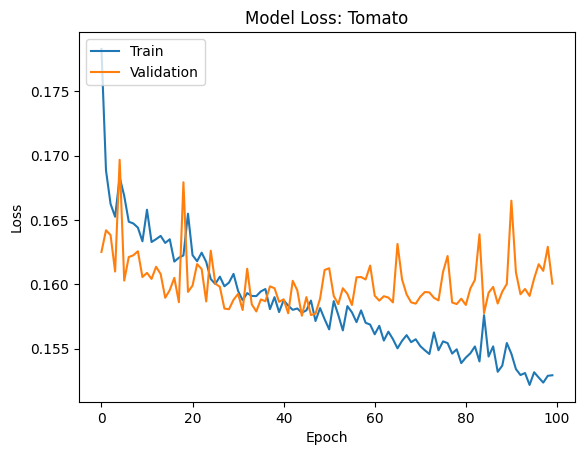

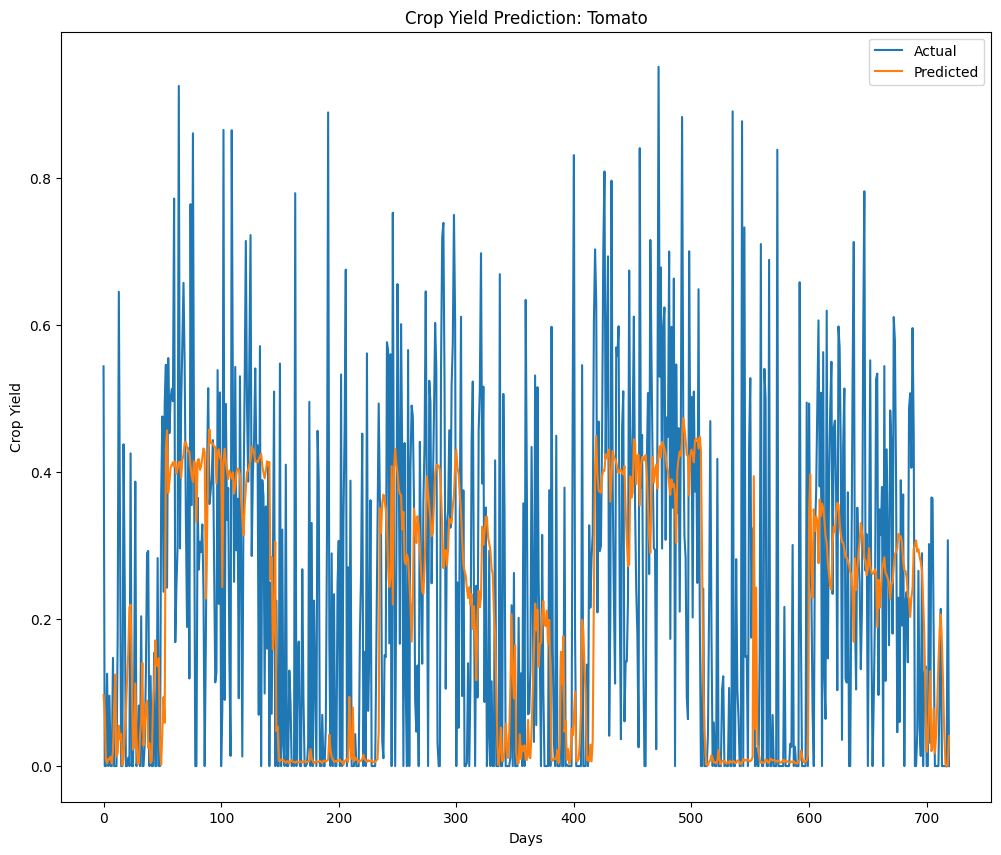

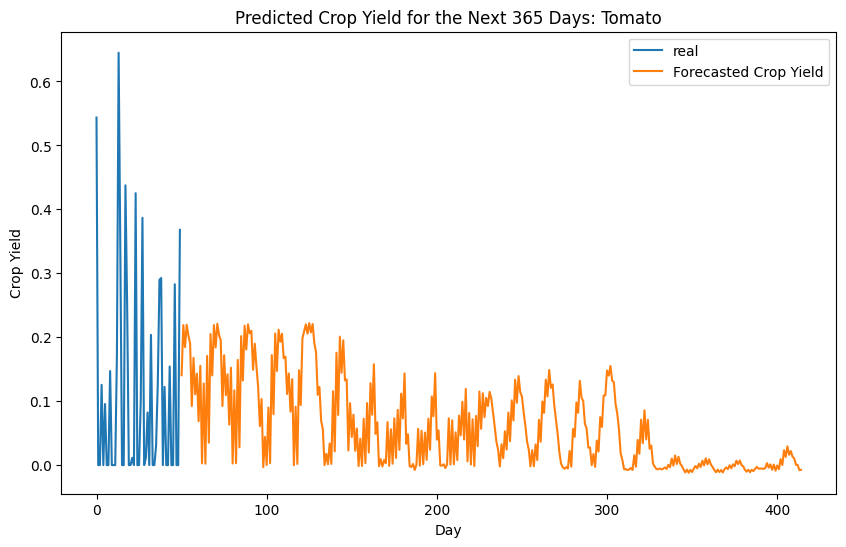

In [34]:
name3 = "Tomato"
create_forecast(tomato, name3)

# **POTATO**

trainX Shape--  (2912, 10, 2)
trainY Shape--  (2912,)
Best Parameters: {'layers': 2, 'units1': 150, 'units2': 50}
Best RMSE: 0.3276
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.2130 - val_loss: 0.1548
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1549 - val_loss: 0.1469
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1493 - val_loss: 0.1480
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1546 - val_loss: 0.1466
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1492 - val_loss: 0.1456
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1546 - val_loss: 0.1461
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1499 - val_loss: 0.1456
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1509 - val_loss: 0.1440
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1502 - val_loss: 0.1459
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1506 - val_loss: 0.1440
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1502 - val_loss: 0.1446
Epoch 12/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1

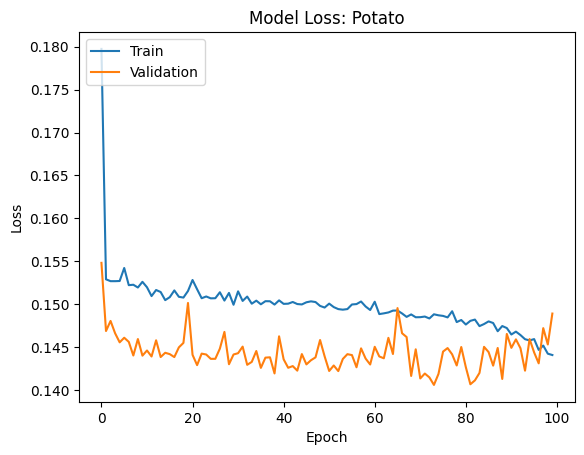

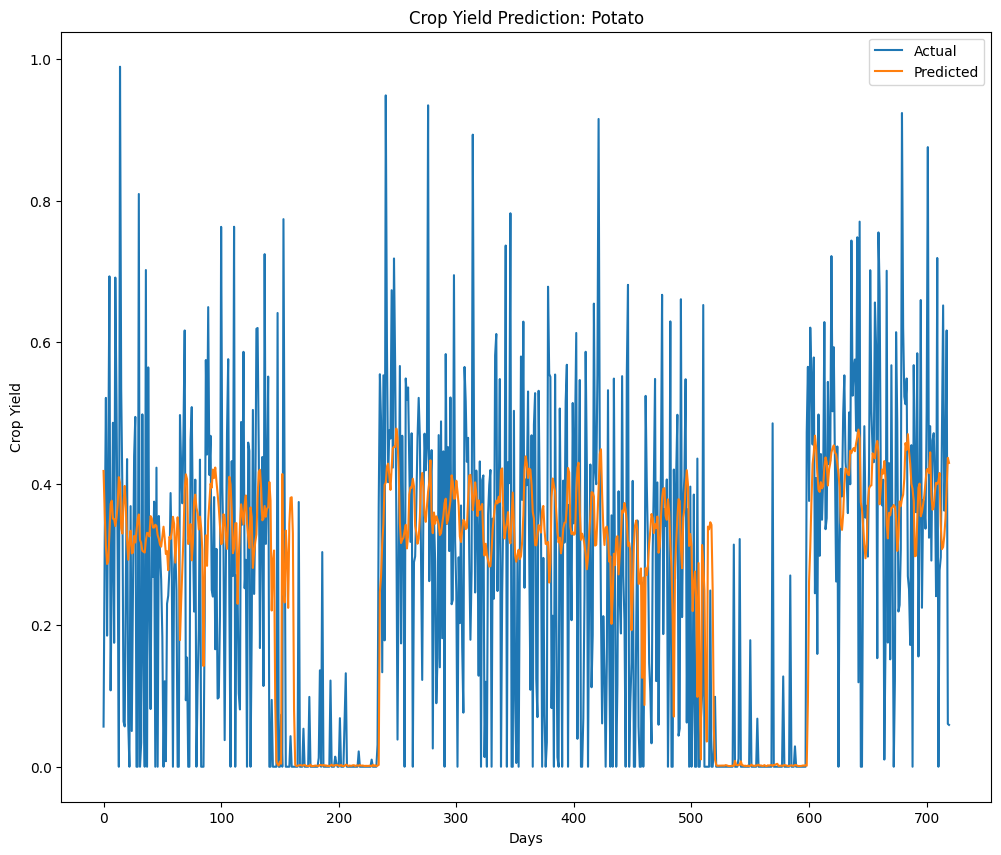

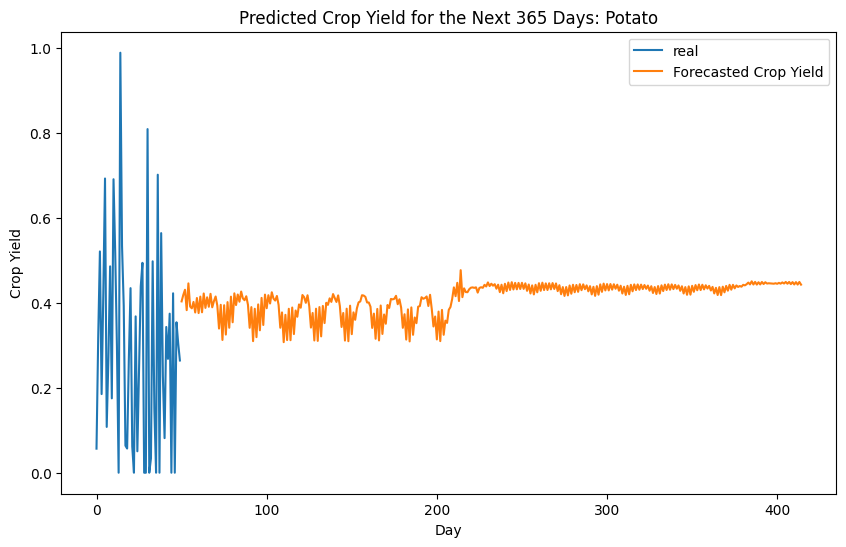

In [36]:
name4 = "Potato"
create_forecast(potato, name4)